In [158]:
from time import sleep
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
from glob import glob

In [159]:
#Menyiapkan proses main loop gambar
frame_count = 0    
frame_count_out=0 

In [160]:
# Inisiliasasi Parameter
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Lebar pada input gambar
inpHeight = 416      #Tinggi pada input gambar

In [161]:
# Melakukan laoding nama class
classesFile = "obj.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [162]:
# Memberikan file konfigurasi dan bobot untuk model yang digunakan
modelConfiguration = "yolov3-obj.cfg";
modelWeights = "yolov3-obj_2400.weights";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

In [163]:
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

In [164]:
# Membuat garis kotak untuk yang diprediksi
def drawPred(classId, conf, left, top, right, bottom):

    global frame_count
    # Membuat Garis Kotak
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    label = '%.2f' % conf
    # Mengambil Label dari class
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    # Menampilkan label diatas garis kotak
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])

    label_name,label_conf = label.split(':')   
    if label_name == 'Helm':
                                            
        cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
        cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)
        frame_count+=1

    if(frame_count> 0):
        return frame_count

In [165]:
# Melakukan penghapusan garis kotak dengan prediksi rendah
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    global frame_count_out
    frame_count_out=0
    classIds = []
    confidences = []
    boxes = []
   
    classIds = []            
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    count_person=0 
    for i in indices:
        i = i
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
               
        frame_count_out = drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

        # Melakukan pengecekan class Helm

        my_class='Helm'                  
        unknown_class = classes[classId]

        if my_class == unknown_class:
            count_person += 1

    print(frame_count_out)


    if count_person >= 1:
        path = 'test_out/'
        frame_name=os.path.basename(fn)             # Meringkas direktori lalu diberi nama.
        cv.imwrite(str(path)+frame_name, frame)     # Cetak ke folder.

        cv.imshow('img',frame)
        cv.waitKey(800)

In [166]:
# Melakukan Proses Input
winName = 'Deep learning object detection in OpenCV'
cv.namedWindow(winName, cv.WINDOW_NORMAL)



for fn in glob('images/*.jpg'):
    frame = cv.imread(fn)
    frame_count =0

    # Membuat Blob dari gambar.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    postprocess(frame, outs)
    
    # Memasukan Informasi Efisiensi. Serta menambahkan status jumlah kesimpulan sementara pada prediksi setiap gambar
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

0
0
1
1
1
0
0
1
1
1
1
1
1
0
0
0
1
1
0
1
0
1
1
0
0
1
0
0
0
0
0
0
0
2
1
1
1
0
1
1
1
1
0
1
0
1
0
0
0
0
3
1
0
1
0
1
0
1
1
1
2
1
1
1
0
3
1
0
1
1
0
0
0
1


In [167]:
# Membuat sebuah Model YOLOv3 Keras dan menyimpan ke file baru
# Berdasarkan https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model


def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model


class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

In [168]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes


def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# Loading dan menyiapkan gambar
def load_image_pixels(filename, shape):
    # Load gambar untuk mendapatkan shape
    image = load_img(filename)
    width, height = image.size
    # Load gambar sesuai ukuran yang dibutuhkan
    image = load_img(filename, target_size=shape)
    # Melakukan konversi ke numpy array
    image = img_to_array(image)
    # Memperbesar piksel ke nilai [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # Menambahkan dimensi pada gambar
    image = expand_dims(image, 0)
    return image, width, height
 
# Mengambil semua hasil dari Threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            # Melakukan pengecekan Threshold
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)

    return v_boxes, v_labels, v_scores
 
# Menggambar semua hasil
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # Loading Gambar
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()

    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # Mendapatkan Koordinat
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Menghitung lebar dan tinggi gambar
        width, height = x2 - x1, y2 - y1
        # membuat shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # Menggabar garis kotak
        ax.add_patch(rect)
        # Menggambar label dan score
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()

In [169]:
# Menerapkan Model Yolov3
model = make_yolov3_model()

# loading model weights
# Model weight terdapat di https://pjreddie.com/darknet/yolo/
weight_reader = WeightReader('yolov3.weights')

# Settin model weights ke model keras
weight_reader.load_weights(model)

# Simpan model sebagai file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [170]:
# loading yolov3 model keras
from keras.models import load_model
model = load_model('model.h5')

In [171]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_5[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                         

                                                                                                  
 bnorm_9 (BatchNormalization)   (None, None, None,   256         ['conv_9[0][0]']                 
                                64)                                                               
                                                                                                  
 leaky_9 (LeakyReLU)            (None, None, None,   0           ['bnorm_9[0][0]']                
                                64)                                                               
                                                                                                  
 conv_10 (Conv2D)               (None, None, None,   73728       ['leaky_9[0][0]']                
                                128)                                                              
                                                                                                  
 bnorm_10 

                                256)                                                              
                                                                                                  
 bnorm_20 (BatchNormalization)  (None, None, None,   1024        ['conv_20[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_20 (LeakyReLU)           (None, None, None,   0           ['bnorm_20[0][0]']               
                                256)                                                              
                                                                                                  
 add_28 (Add)                   (None, None, None,   0           ['add_27[0][0]',                 
                                256)                              'leaky_20[0][0]']               
          

 conv_32 (Conv2D)               (None, None, None,   294912      ['leaky_31[0][0]']               
                                256)                                                              
                                                                                                  
 bnorm_32 (BatchNormalization)  (None, None, None,   1024        ['conv_32[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_32 (LeakyReLU)           (None, None, None,   0           ['bnorm_32[0][0]']               
                                256)                                                              
                                                                                                  
 add_32 (Add)                   (None, None, None,   0           ['add_31[0][0]',                 
          

                                                                                                  
 add_35 (Add)                   (None, None, None,   0           ['add_34[0][0]',                 
                                512)                              'leaky_42[0][0]']               
                                                                                                  
 conv_44 (Conv2D)               (None, None, None,   131072      ['add_35[0][0]']                 
                                256)                                                              
                                                                                                  
 bnorm_44 (BatchNormalization)  (None, None, None,   1024        ['conv_44[0][0]']                
                                256)                                                              
                                                                                                  
 leaky_44 

                                512)                                                              
                                                                                                  
 add_39 (Add)                   (None, None, None,   0           ['add_38[0][0]',                 
                                512)                              'leaky_54[0][0]']               
                                                                                                  
 conv_56 (Conv2D)               (None, None, None,   131072      ['add_39[0][0]']                 
                                256)                                                              
                                                                                                  
 bnorm_56 (BatchNormalization)  (None, None, None,   1024        ['conv_56[0][0]']                
                                256)                                                              
          

 bnorm_66 (BatchNormalization)  (None, None, None,   2048        ['conv_66[0][0]']                
                                512)                                                              
                                                                                                  
 leaky_66 (LeakyReLU)           (None, None, None,   0           ['bnorm_66[0][0]']               
                                512)                                                              
                                                                                                  
 conv_67 (Conv2D)               (None, None, None,   4718592     ['leaky_66[0][0]']               
                                1024)                                                             
                                                                                                  
 bnorm_67 (BatchNormalization)  (None, None, None,   4096        ['conv_67[0][0]']                
          

                                                                                                  
 leaky_77 (LeakyReLU)           (None, None, None,   0           ['bnorm_77[0][0]']               
                                512)                                                              
                                                                                                  
 conv_78 (Conv2D)               (None, None, None,   4718592     ['leaky_77[0][0]']               
                                1024)                                                             
                                                                                                  
 bnorm_78 (BatchNormalization)  (None, None, None,   4096        ['conv_78[0][0]']                
                                1024)                                                             
                                                                                                  
 leaky_78 

                                128)                                                              
                                                                                                  
 bnorm_96 (BatchNormalization)  (None, None, None,   512         ['conv_96[0][0]']                
                                128)                                                              
                                                                                                  
 leaky_96 (LeakyReLU)           (None, None, None,   0           ['bnorm_96[0][0]']               
                                128)                                                              
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, None, None,   0          ['leaky_96[0][0]']               
                                128)                                                              
          

 leaky_104 (LeakyReLU)          (None, None, None,   0           ['bnorm_104[0][0]']              
                                256)                                                              
                                                                                                  
 conv_81 (Conv2D)               (None, None, None,   261375      ['leaky_80[0][0]']               
                                255)                                                              
                                                                                                  
 conv_93 (Conv2D)               (None, None, None,   130815      ['leaky_92[0][0]']               
                                255)                                                              
                                                                                                  
 conv_105 (Conv2D)              (None, None, None,   65535       ['leaky_104[0][0]']              
          

In [172]:
# Parameter titik pusat yang digunakan pada dataset
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# Menentukan bentuk input pada model
WIDTH, HEIGHT = 416, 416

# Menentukan nilai ambang batas pada objek yang terdeteksi
class_threshold = 0.3

In [173]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
images = os.listdir('training_images/')[:10]

In [174]:
from numpy import expand_dims
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Loading dan menyiapkan gambar
def load_image_pixels(filename, shape):
    '''
    Function preprocess the images to 416x416, which is the standard input shape for YOLOv3, 
    and also keeps track of the originl shape, which is later used to draw the boxes.
    
    paramters:
    filename {String}: path to the image
    shape {tuple}: shape of the input dimensions of the network
    
    returns:
    image {PIL}: image of shape 'shape'
    width {int}: original width of the picture
    height {int}: original height of the picture
    '''

    image = load_img(filename)
    width, height = image.size

    image = load_img(filename, target_size=shape)
    

    image = img_to_array(image)
    

    image = image.astype('float32')
    image /= 255.0
    
    image = expand_dims(image, 0)
    return image, width, height

In [175]:
for file in images:
    photo_filename = 'training_images/' + file
    
    # loading gambar
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    
    # Melakukan prediksi pada gambar
    yhat = model.predict(image)
    
    # Membuat garis kotak
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

    do_nms(boxes, 0.5)

    # Menentukan label
    labels = ["helmet"]

    # Mengambail detail dari objek yang terdeteksi
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    # Meringkas semua yang terdeteksi
    for i in range(len(v_boxes)):

        print(v_labels[i], v_scores[i])

1/1 [==============================] - 5s 5s/step
helmet 99.88565444946289
1/1 [==============================] - 2s 2s/step
helmet 99.9483585357666
1/1 [==============================] - 2s 2s/step
helmet 99.70864057540894
helmet 99.97274875640869
helmet 98.91010522842407
helmet 97.91685342788696
1/1 [==============================] - 2s 2s/step
helmet 99.68725442886353
helmet 99.37682151794434
helmet 98.7932026386261
helmet 99.40498471260071
1/1 [==============================] - 2s 2s/step
helmet 99.8884379863739
1/1 [==============================] - 2s 2s/step
helmet 99.91893768310547
1/1 [==============================] - 2s 2s/step
helmet 99.85576868057251
1/1 [==============================] - 2s 2s/step
helmet 99.8935878276825
1/1 [==============================] - 2s 2s/step
helmet 99.80072975158691
1/1 [==============================] - 2s 2s/step
helmet 32.877543568611145
helmet 98.40463399887085


In [176]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
images = os.listdir('images/training_data')[:10]
train_dir = 'images/training_data'
val_dir = 'images/validation_data'
test_dir = 'images/testing_data'

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [199]:
# Membuat 3 variabel dataset train_ds, val_ds, test_ds

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 105 files belonging to 2 classes.
Found 70 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


['helm', 'tanpa_helm']


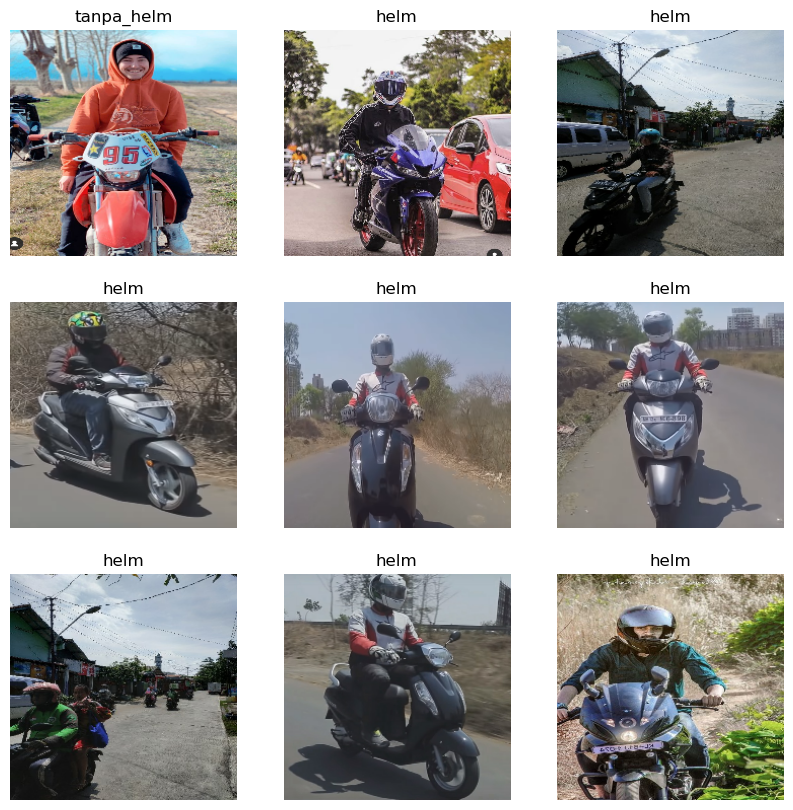

In [179]:
# Menampilkan label dan gambar pada data training

label_names = train_ds.class_names

print(label_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label_names[labels[i]])
    plt.axis("off")

In [180]:
#Melakukan Autotune dan Augmentasi Data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds= val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.2),
])

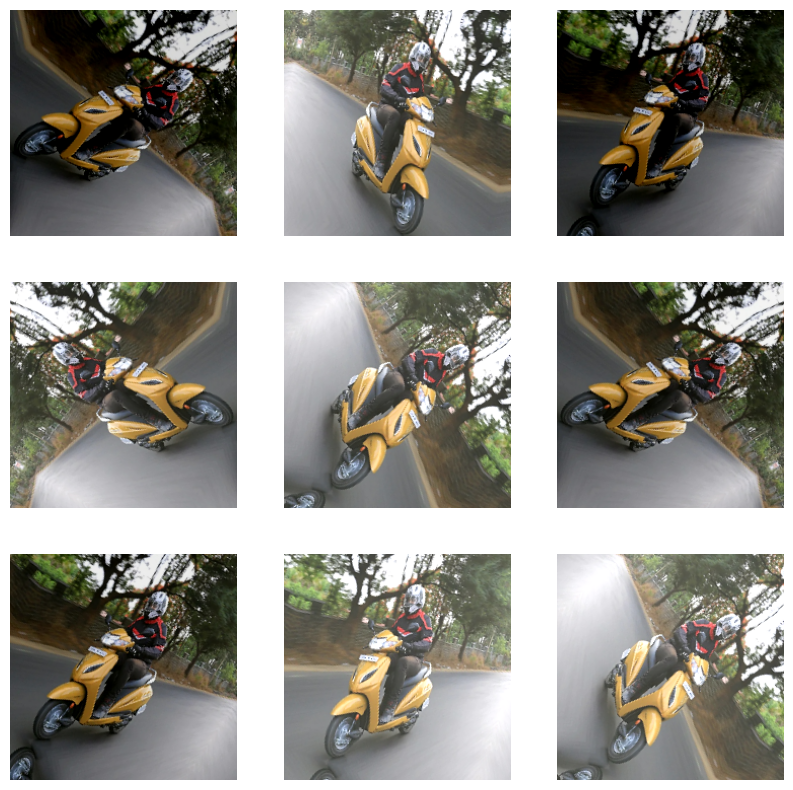

In [181]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [182]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
IMG_SHAPE = (IMG_SIZE) + (3,)
yolov3_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

yolov3_model.trainable = False
image_batch, label_batch = next(iter(train_ds))
feature_batch = yolov3_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [183]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [184]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [185]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = yolov3_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [186]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [187]:
initial_epochs = 5
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/5
7/7 [==============================] - 146s 21s/step - loss: 1.6609 - accuracy: 0.6857 - val_loss: 1.4503 - val_accuracy: 0.5571
Epoch 2/5
7/7 [==============================] - 141s 21s/step - loss: 1.5253 - accuracy: 0.7048 - val_loss: 1.4007 - val_accuracy: 0.5429
Epoch 3/5
7/7 [==============================] - 143s 22s/step - loss: 1.6442 - accuracy: 0.6190 - val_loss: 1.3586 - val_accuracy: 0.5571
Epoch 4/5
7/7 [==============================] - 144s 22s/step - loss: 1.5989 - accuracy: 0.6667 - val_loss: 1.2675 - val_accuracy: 0.5286
Epoch 5/5
7/7 [==============================] - 147s 22s/step - loss: 1.3826 - accuracy: 0.6571 - val_loss: 1.2213 - val_accuracy: 0.5286


In [189]:
# Melakukan fine tunning
yolov3_model.trainable = True

fine_tune_at = 13

for layer in yolov3_model.layers[:fine_tune_at]:
  layer.trainable = False

In [190]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [191]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/20
7/7 [==============================] - 183s 26s/step - loss: 1.1537 - accuracy: 0.6952 - val_loss: 1.2105 - val_accuracy: 0.5571
Epoch 6/20
7/7 [==============================] - 179s 27s/step - loss: 1.0582 - accuracy: 0.7238 - val_loss: 1.1219 - val_accuracy: 0.5143
Epoch 7/20
7/7 [==============================] - 180s 27s/step - loss: 0.9784 - accuracy: 0.7333 - val_loss: 1.2149 - val_accuracy: 0.5429
Epoch 8/20
7/7 [==============================] - 185s 28s/step - loss: 0.6310 - accuracy: 0.7714 - val_loss: 1.1804 - val_accuracy: 0.5571
Epoch 9/20
7/7 [==============================] - 181s 27s/step - loss: 0.5363 - accuracy: 0.8095 - val_loss: 1.2300 - val_accuracy: 0.5429
Epoch 10/20
7/7 [==============================] - 181s 27s/step - loss: 0.7186 - accuracy: 0.7810 - val_loss: 1.1860 - val_accuracy: 0.5571
Epoch 11/20
7/7 [==============================] - 182s 27s/step - loss: 0.4865 - accuracy: 0.8190 - val_loss: 1.1137 - val_accuracy: 0.5571
Epoch 12/20
7/7 [=

In [201]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

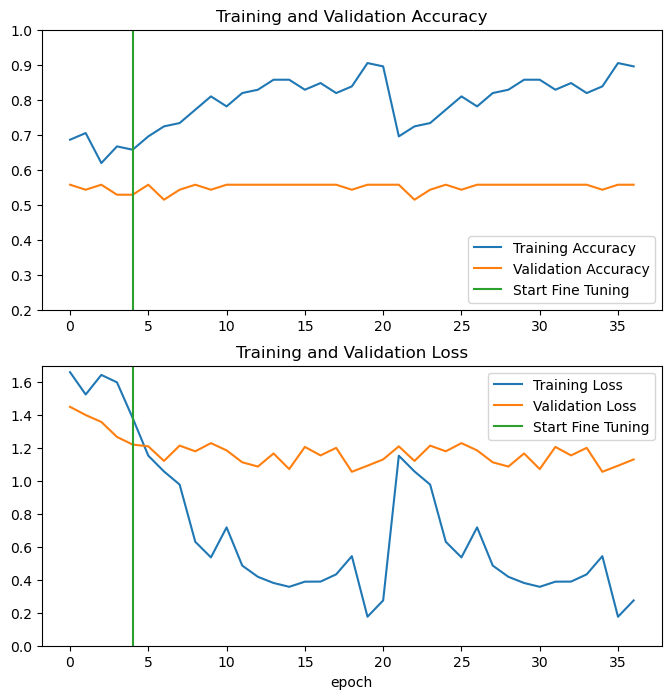

In [202]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.7])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [203]:
loss, accuracy = model.evaluate(train_ds)

# Mengambil kumpulan gambar dari dataset
image_batch, label_batch = train_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Menerapkan sigmoid dari model menampilkan logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.1, 0, 1)

7/7 [==============================] - 83s 12s/step - loss: 0.1481 - accuracy: 0.9238


In [204]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada model Testing
y_pred = model.predict(test_ds)

# Membuat classification report
report = classification_report(label_batch, predictions, target_names=label_names)
print(report)

4/4 [==============================] - 48s 12s/step
              precision    recall  f1-score   support

        helm       1.00      0.92      0.96        13
  tanpa_helm       0.75      1.00      0.86         3

    accuracy                           0.94        16
   macro avg       0.88      0.96      0.91        16
weighted avg       0.95      0.94      0.94        16



4/4 [==============================] - 47s 11s/step


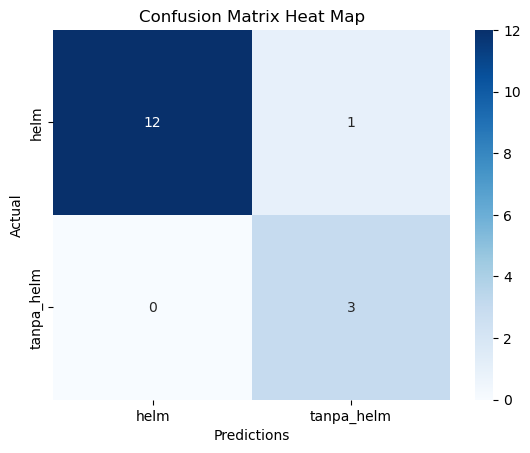

In [205]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
# memprediksi label dari data uji menggunakan model testing
y_pred = model.predict(test_ds)


# Menambahkan prediksi dan kelas aktual ke confusion matrix
confusion_matrix = pd.crosstab(label_batch, predictions, rownames=['Actual'], colnames=['Predictions'])

# Tampilkan heat map confusion matrix menggunakan seaborn
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predictions')
plt.title('Confusion Matrix Heat Map')
plt.show()